In [1]:
import chess.engine  
from IPython.display import clear_output
import time
import pandas as pd
import re
import chess.pgn
from collections import Counter # for calculating captured pieces
import math
import numpy as np
import io
from tqdm import tqdm

stockfish_path = "stockfish-windows-x86-64-avx2.exe"


In [2]:
openings_df = pd.read_csv("openings_master.csv")
# only 2 openings have more than 12 moves

In [3]:
def search_opening(dataframe, pgn):

    # Check if the search_string is in column 'A'
    mask = dataframe['pgn'] == pgn

    # If there is a match, return the corresponding value in column 'B'
    if any(mask):
        return dataframe.loc[mask, 'name'].iloc[0]
    else:
        return None

### Useful snippets

In [4]:
'''chess.parse_square('f3')
file_rank = chess.square_name(square_int)


uci_move = chess.Move.from_uci("g3g4")
board.push(uci_move)
board.push_san

[(chess.PAWN, 1),
(chess.BISHOP, 3),
(chess.KING, 0),
(chess.QUEEN, 9),
(chess.KNIGHT, 3),
(chess.ROOK, 5)]'''

'chess.parse_square(\'f3\')\nfile_rank = chess.square_name(square_int)\n\n\nuci_move = chess.Move.from_uci("g3g4")\nboard.push(uci_move)\nboard.push_san\n\n[(chess.PAWN, 1),\n(chess.BISHOP, 3),\n(chess.KING, 0),\n(chess.QUEEN, 9),\n(chess.KNIGHT, 3),\n(chess.ROOK, 5)]'

## Testing

Look for defended pieces

In [5]:
def check_for_defended_pieces(board):
    for hanging_square in chess.SQUARES:
        maybe_hanging_piece = board.piece_at(hanging_square)
        if maybe_hanging_piece is not None:

            for defending_square in chess.SQUARES: # see if attacked piece has defenders
                maybe_defending_piece = board.piece_at(defending_square)
                if (maybe_defending_piece is not None) and (maybe_hanging_piece.color == maybe_defending_piece.color):

                    if hanging_square in list(board.attacks(defending_square)): # check if attacked piece's square is on the attacks (is defended by) of another piece
                        print(f'{board.piece_at(hanging_square)} is defended by the {board.piece_at(defending_square)}')

def is_defended(board: chess.Board, square, by_color=None, return_list_of_defenders=False):

    piece = board.piece_at(square)

    if by_color is None:
        defenders = board.attackers(piece.color, square)
    else:
        defenders = board.attackers(by_color, square)

    if return_list_of_defenders:
        return defenders
    
    if len(defenders) > 0:
        return True
    
    return False

Look for vulnerable/hanging pieces

In [6]:
def check_for_hanging_pieces(board, return_list_of_hanging=False, fr_format=False):

    hanging_pieces = []
    hanging_pieces_and_attackers = dict()

    for square in chess.SQUARES:
        maybe_hanging_piece = board.piece_at(square)
        
        if (maybe_hanging_piece is not None):
            if not (is_defended(board, square)):
                attackers = list(board.attackers(not maybe_hanging_piece.color, square))
                if len(attackers) > 0:

                    if fr_format:
                        hanging_pieces_and_attackers[chess.square_name(square)] = [chess.square_name(s) for s in attackers]
                        hanging_pieces.append(chess.square_name(square))
                    else:
                        hanging_pieces_and_attackers[square] = attackers
                        hanging_pieces.append(square)
                        #print(f'The {maybe_hanging_piece} is left hanging and can be captured by {', '.join(str(board.piece_at(p)) for p in attackers)}')


    if return_list_of_hanging:
        return hanging_pieces
    else:
        return hanging_pieces_and_attackers

def is_hanging(board: chess.Board, square, capturable_by=None, return_list_of_attackers=False):
    maybe_hanging_piece = board.piece_at(square)

    if capturable_by is None:
        square_is_defended = is_defended(board, square)


        if not square_is_defended:
            attackers = list(board.attackers(not maybe_hanging_piece.color, square))
            if len(attackers) > 0:
                if return_list_of_attackers:
                    return attackers
                else:
                    return True
            else:
                return False
    else:
        square_is_defended = is_defended(board, square, not capturable_by)

        if not square_is_defended:
            attackers = list(board.attackers(capturable_by, square))
        
            if len(attackers) > 0:
                if return_list_of_attackers:
                    return attackers
                else:
                    return True
            else:
                return False
    
        
    return False
        
def move_hangs_piece(board: chess.Board, move, return_hanging_squares=False):
    #move = board.parse_san(move)

    position_after_move = board.copy()
    position_after_move.push(move)

    hanging_before = check_for_hanging_pieces(board, return_list_of_hanging=True)
    hanging_after = check_for_hanging_pieces(position_after_move, return_list_of_hanging=True)

    if return_hanging_squares:
        return hanging_after
    else:
        if hanging_before == hanging_after:
            return False
        else:
            return True


Checking if move defends a hanging piece

In [7]:
def move_defends_hanging_piece(board: chess.Board, move, return_list_defended=False):

    if board.is_castling(move):
        if return_list_defended:
            return []
        return False
    #move = board.parse_san(move)
    
    position_after_move = board.copy()
    position_after_move.push(move)

    defended_squares = []
    for defended_square in position_after_move.attacks(move.to_square):
        defended_piece = position_after_move.piece_at(defended_square)
        if (defended_piece is not None) and (defended_piece.color == board.turn):
            if not is_defended(board, defended_square, by_color=board.turn):
                defended_squares.append(defended_square)
    
    if return_list_defended:
        return defended_squares

    if len(defended_squares > 0):
        return True
    else:
        return False



Detecting moves that create forks, miss forks, and allows forks

In [8]:
def move_creates_fork(board: chess.Board, move, return_forked_squares=False):        

    position_after_move = board.copy()
    position_after_move.push(move)

    return is_forking(position_after_move, move.to_square, return_forked_squares)

In [9]:
def move_allows_fork(board: chess.Board, move, return_forking_moves=False):
    
    forking_moves = []

    position_after_move = board.copy()
    position_after_move.push(move)

    for maybe_forking_move in position_after_move.legal_moves:
        if move_creates_fork(position_after_move, maybe_forking_move):
            forking_moves.append(maybe_forking_move)

    if return_forking_moves:
        return forking_moves
    
    if len(forking_moves) == 0:
        return False
    else:
        return True

In [10]:
def move_misses_fork(board: chess.Board, move, return_forking_moves=False):
    forking_moves = []

    for maybe_fork_move in board.legal_moves:
        if move_creates_fork(board, maybe_fork_move):
            forking_moves.append(maybe_fork_move)

    if return_forking_moves:
        return forking_moves
        
    if move in forking_moves:
        return False
    else:
        return True
        

In [11]:
def is_forking(board: chess.Board, square, return_forked_squares=False):
    forked_squares = []

    square_can_be_captured_by = not board.piece_at(square).color

    if len(board.attackers(square_can_be_captured_by, square)) > 0:
        if return_forked_squares:
            return []
        return False

    attacks = board.attacks(square)
    for attacked_square in attacks:
        attacked_piece = board.piece_at(attacked_square)
        if (attacked_piece is not None) and (attacked_piece.color != board.piece_at(square).color):
            if not is_defended(board, attacked_square):
                forked_squares.append(attacked_square)
            else:
                if board.piece_type_at(attacked_square) > board.piece_type_at(square):
                    forked_squares.append(attacked_square)

                elif board.piece_type_at(attacked_square) < board.piece_type_at(square):
                    if str(attacked_piece).lower() == 'k':
                        forked_squares.append(attacked_square)

    if return_forked_squares:
        return forked_squares
    
    else:   

        if len(forked_squares) >= 2:
            return True

        else:
            return False

See if move blocks a check

In [12]:
def move_blocks_check(board: chess.Board, move):

    #move = board.parse_san(move)

    if (board.is_check()) and (not board.is_capture(move)):

        king_square = board.king(board.turn)   
        position_after_move = board.copy()
        position_after_move.push(move)

        if str(position_after_move.piece_at(king_square)).lower() == 'k':
            return True
        else:
            return False
        
    else:
        return False

Evaluation function

In [13]:
def evaluate(board, time_limit=0.25, return_mate_n=False):
    with chess.engine.SimpleEngine.popen_uci(stockfish_path) as engine:
        info = engine.analyse(board, chess.engine.Limit(time=time_limit))

    possible_mate_score = str(info['score'].relative)
    if '#' in possible_mate_score:

        n = abs(int(possible_mate_score.replace("#", '')))

        if '+' in possible_mate_score:
            if board.turn == True: # if black played the mate move
                if return_mate_n:
                    return 10000, n
                else:
                    return 10000
            else: # if white played the mate move
                if return_mate_n:
                    return -10000, n
                else:
                    return -10000
        else:
            if board.turn == True: # if black played the mate move
                if return_mate_n:
                    return -10000, n
                else:
                    return -10000
            else: # if white played the mate move
                if return_mate_n:
                    return 10000, n
                else:
                    return 10000

    # handle error if score is none when mate in n
    if board.turn == True:
        score = info['score'].relative.score()
    elif board.turn == False:
        score = -info['score'].relative.score() # transform score to absolute score (pos in favor of white, neg in favor black)

    if return_mate_n:
        return score, None
    else:
        return score

def evaluate_relative(board, time_limit=0.25):
    with chess.engine.SimpleEngine.popen_uci(stockfish_path) as engine:
        info = engine.analyse(board, chess.engine.Limit(time=time_limit))

    possible_mate_score = str(info['score'].relative)
    if '#' in possible_mate_score:
        if '+' in possible_mate_score:
            return 10000
        else:
            return -10000

    # handle error if score is none when mate in n
    score = info['score'].relative.score()
    return score

Check if board has mate in n

In [14]:
def has_mate_in_n(board, time_limit=0.2):
    with chess.engine.SimpleEngine.popen_uci(stockfish_path) as engine:
        info = engine.analyse(board, chess.engine.Limit(time=time_limit))

        if '#' in str(info['score'].relative):
            return True
        else:
            return False

In [15]:
def move_allows_mate(board: chess.Board, move, time_limit=0.2, return_winning_player=False):
    #move = board.parse_san(move)
    position_after_move = board.copy()
    position_after_move.push(move)

    with chess.engine.SimpleEngine.popen_uci(stockfish_path) as engine:
        info = engine.analyse(position_after_move, chess.engine.Limit(time=time_limit))

    score = str(info['score'].relative)

    if return_winning_player:
        if '#' not in score:
            return None
        else:
            if '+' in score:
                return not board.turn
            elif '-' in score:
                return board.turn

    if '#' not in score:
        return False
    else:
        return True


How many points gained for a move

In [16]:
def calculate_points_gained_by_move(board: chess.Board, move, time_limit=0.25, **kwargs):
    previous_score = evaluate(board, time_limit)

    position_after_move = board.copy()
    position_after_move.push(move)

    current_score, n = evaluate(position_after_move, time_limit, return_mate_n=True)
    
    #points_gained = calculate_points_gained(position_after_move, previous_score, time_limit)

    #print(previous_score, current_score)

    if board.turn == True:

        if (previous_score != 10000) and (current_score == 10000):
            return f'mates {n}'
        elif (previous_score == 10000) and (current_score == 10000):
            return f'mates {n}'
        elif (previous_score == -10000) and (current_score == -10000):
            return f'continues gets mated {n}'
        elif (previous_score != -10000) and (current_score == -10000):
            return f'gets mated {n}'
        elif (previous_score == 10000) and (current_score != 10000):
            return f'lost mate'
        
        points_gained = current_score - previous_score

    else:

        if (previous_score != -10000) and (current_score == -10000):
            return f'mates {n}'
        elif (previous_score == -10000) and (current_score == -10000):
            return f'mates {n}'
        elif (previous_score == 10000) and (current_score == 10000):
            return f'continues gets mated {n}'
        elif (previous_score != 10000) and (current_score == 10000):
            return f'gets mated {n}'
        elif (previous_score == -10000) and (current_score != -10000):
            return f'lost mate'

        points_gained = previous_score - current_score

    return points_gained

In [17]:
board = chess.Board('6k1/p4ppp/8/1b2q3/2p3K1/4r3/P3N1PP/5R2 b - - 1 32')
move = chess.Move.from_uci('b5d7')

Classifying moves into 5

In [18]:
def classify_move(board: chess.Board, move, time_limit=0.3):

    points_gained = calculate_points_gained_by_move(board, move, time_limit)

    if type(points_gained) == str:
        # quite redundant put im putting it for clarity
        if 'mates' in points_gained: 
            return points_gained
        elif 'continues gets mated' in points_gained:
            return points_gained
        elif 'gets mated' in points_gained:
            return points_gained
        elif 'lost mate' in points_gained:
            return points_gained

    if (points_gained >= -20):
        return 'excellent'
    elif (points_gained < -20) and (points_gained >= -100):
        return 'good'
    elif (points_gained < -100) and (points_gained >= -250):
        return 'inaccuracy'
    elif (points_gained < -250) and (points_gained >= -450):
        return 'mistake'
    else:
        return 'blunder'


Rank all legal moves from lowest to highest eval

In [19]:
def rank_moves(board: chess.Board, time_limit=0.25, return_dict=False):
    # ascending order
    
    scores = []
    moves = [] # best to worst

    for move in board.legal_moves:

        position_after_move = board.copy()
        position_after_move.push(move)

        score = evaluate(position_after_move, time_limit)
        
        moves.append(move)
        scores.append(score)

    moves = [m for _, m in sorted(zip(scores, moves))]
    scores = sorted(scores)

    if return_dict:
        return {m: s for m, s in zip(moves, scores)}
    else:
        return moves


Detect developing moves

In [20]:
def is_developing_move(board: chess.Board, move):
    #move = board.parse_san(move)

    if move.from_square in [chess.B1, chess.G1, chess.B8, chess.G8]:
        if str(board.piece_at(move.from_square)).lower() == 'n':
            return 'N'
        else:
            return False
    elif move.from_square in [chess.C1, chess.F1, chess.C8, chess.F8]:
        if str(board.piece_at(move.from_square)).lower() == 'b':
            return 'B'
        else:
            return False
    elif move.from_square in [chess.C1, chess.F1, chess.C8, chess.F8]:
        if str(board.piece_at(move.from_square)).lower() == 'q':
            return 'Q'
        else:
            return False
    elif move.from_square in [chess.H1, chess.A1, chess.H8, chess.A8]:
        if str(board.piece_at(move.from_square)).lower() == 'r':
            return 'R'
        else:
            return False
    else:
        return False

In [21]:
def is_fianchetto(board: chess.Board, move):
    #move = board.parse_san(move)

    if str(board.piece_at(move.from_square)).lower() == 'b':
        if move.from_square in [chess.C1, chess.F1, chess.C8, chess.F8]:
            if move.to_square in [chess.B2, chess.G2, chess.B7, chess.G7]:
                return True
        
    return False

Check for future threats/attacks

In [22]:
def check_for_threats(board: chess.Board, time_limit=0.25, moves_ahead=2, take_turns=False, by_opponent=True):

    assert not board.is_check()

    threat_moves = []

    opponent_color = not board.turn
    
    if take_turns:
        with chess.engine.SimpleEngine.popen_uci(stockfish_path) as engine:
            info = engine.analyse(board, chess.engine.Limit(time=time_limit))

        threat_moves = info['pv'][:moves_ahead]

    else:

        experiment_board = board.copy()
        for i in range(moves_ahead):
            experiment_board = chess.Board(experiment_board.fen())
            if by_opponent:
                experiment_board.turn = opponent_color
            else:
                experiment_board.turn = not opponent_color
            with chess.engine.SimpleEngine.popen_uci(stockfish_path) as engine:
                info = engine.analyse(experiment_board, chess.engine.Limit(time=time_limit))
            
            best_move = info['pv'][0]
            threat_moves.append(best_move)
            experiment_board.push(best_move)

            if experiment_board.is_check():
                break


    return threat_moves

In [23]:
def is_possible_trade(board: chess.Board, move):
    #move = board.parse_san(move)
    
    if board.is_capture(move):
        
        if is_defended(board, move.to_square, by_color=not board.turn):
            if board.piece_type_at(move.to_square) == board.piece_type_at(move.from_square):
                return True
            elif (board.piece_type_at(move.to_square) == 2) and (board.piece_type_at(move.from_square) == 3):
                return True
            elif (board.piece_type_at(move.to_square) == 3) and (board.piece_type_at(move.from_square) == 2):
                return True
            else:
                return False
        else:
            return False
    else:
        attackers = list(board.attackers(not board.turn, move.to_square))
        if len(attackers) > 0:
            for attacking_square in attackers:
                if is_defended(board, move.to_square, by_color=board.turn):
                    if board.piece_type_at(attacking_square) == board.piece_type_at(move.from_square):
                        if not board.is_pinned(not board.turn, attacking_square):
                            return True
                    elif (board.piece_type_at(attacking_square) == 2) and (board.piece_type_at(move.from_square) == 3):
                        return True
                    elif (board.piece_type_at(attacking_square) == 3) and (board.piece_type_at(move.from_square) == 2):
                        return True
                else:
                    return True
            
        
        return False

In [24]:
def move_is_discovered_check(board: chess.Board, move):
    position_after_move = board.copy()
    position_after_move.push(move)

    if position_after_move.is_check():
        for attacked_square in position_after_move.attacks(move.to_square):
            if str(position_after_move.piece_at(attacked_square)).lower() == 'k':
                return False
        return True
        
    return False

In [25]:
def move_is_discovered_check_and_attacks(board: chess.Board, move, return_attacked_squares=False):
    if not move_is_discovered_check(board, move):
        if return_attacked_squares:
            return []
        return False
    
    position_after_move = board.copy()
    position_after_move.push(move)

    attacked_squares = []

    for attacked_square in position_after_move.attacks(move.to_square):
        if position_after_move.piece_at(attacked_square) is not None:
            if is_hanging(position_after_move, attacked_square, capturable_by=board.turn):
                attacked_squares.append(attacked_square)
            elif position_after_move.piece_type_at(attacked_square) > position_after_move.piece_type_at(move.to_square):
                attacked_squares.append(attacked_square)

    if return_attacked_squares:
        return attacked_squares
    
    if len(attacked_squares) > 0:
        return True
    else:
        return False

In [145]:
def is_trapped(board: chess.Board, square, by):

    if str(board.piece_at(square)).lower() == 'k':
        return False

    attackers = board.attackers(by, square)

    capturable_by_lower = False

    for attacking_square in attackers:
        if board.piece_at(attacking_square).color != board.piece_at(square).color:
            if board.piece_type_at(attacking_square) < board.piece_type_at(square):
                capturable_by_lower = True
    
    if not capturable_by_lower:
        return False

    can_be_saved = True

    movable_squares = board.attacks(square)

    for move_to_square in movable_squares:

        if board.piece_at(move_to_square) is None:

            defending_squares = board.attackers(by, move_to_square)
            
            if len(defending_squares) == 0:
                can_be_saved = True
                
                return False

            for defending_square in defending_squares:

                if board.piece_at(defending_square).color != board.piece_at(square).color:

                    if board.piece_type_at(defending_square) < board.piece_type_at(square):
                        if not board.is_pinned(by, defending_square):
                            can_be_saved = False   
                        else:
                            can_be_saved = True
        
                    elif board.piece_type_at(defending_square) == board.piece_type_at(square):
                        if not board.is_pinned(by, defending_square):
                            defenders = is_defended(board, defending_square, by_color=not by, return_list_of_defenders=True)
                            if len(defenders) <= 1: # if the trapped piece is the only defender
                                can_be_saved = False

                    else:
                        can_be_saved = True 

        elif (board.piece_at(move_to_square).color != board.piece_at(square).color) and (board.piece_type_at(move_to_square) <= board.piece_type_at(square)):

            defending_squares = board.attackers(by, move_to_square)
            
            if len(defending_squares) == 0:
                can_be_saved = True
                
                return False

            for defending_square in defending_squares:

                if board.piece_at(defending_square).color != board.piece_at(square).color:

                    if board.piece_type_at(defending_square) < board.piece_type_at(square):
                        if not board.is_pinned(by, defending_square):
                            can_be_saved = False   
                        else:
                            can_be_saved = True
        
                    elif board.piece_type_at(defending_square) == board.piece_type_at(square):
                        if not board.is_pinned(by, defending_square):
                            defenders = is_defended(board, defending_square, by_color=not by, return_list_of_defenders=True)
                            if len(defenders) <= 1: # if the trapped piece is the only defender
                                can_be_saved = False

                    else:
                        can_be_saved = True 

    if not can_be_saved:
        return True
    else:
        return False

In [147]:
is_trapped(board, chess.parse_square('b1'), by=True)

False

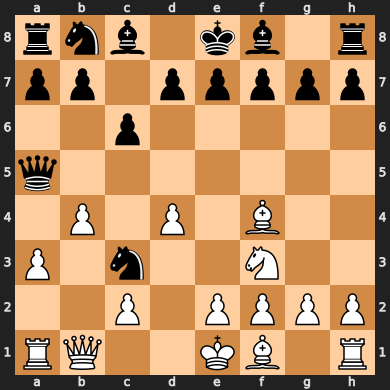

In [146]:
board = chess.Board('rnb1kb1r/pp1ppppp/2p5/q7/1P1P1B2/P1n2N2/2P1PPPP/RQ2KB1R w KQkq - 0 8')
move = chess.Move.from_uci('a3a4')
board

In [27]:
def move_traps_opponents_piece(board: chess.Board, move, return_trapped_squares=False):
    position_after_move = board.copy()
    position_after_move.push(move)

    trapped_squares = []

    for attacked_square in position_after_move.attacks(move.to_square):
        if position_after_move.piece_at(attacked_square) is not None:
            if position_after_move.piece_at(attacked_square).color != position_after_move.piece_at(move.to_square):
                if is_trapped(position_after_move, attacked_square, by=board.turn):
                    trapped_squares.append(attacked_square)

    if return_trapped_squares:
        return trapped_squares
    
    if len(trapped_squares) > 0:
        return True
    else:
        return False

In [28]:
def is_possible_sacrifice(board: chess.Board, move):

    if str(board.piece_at(move.from_square)).lower() == 'p':
        return False

    if board.is_capture(move):
        defending_squares = is_defended(board, move.to_square, by_color=not board.turn, return_list_of_defenders=True)

        if len(defending_squares) > 0:
            
            if board.piece_type_at(move.to_square) < board.piece_type_at(move.from_square):
                
                if (board.piece_type_at(move.to_square) != 2) or (board.piece_type_at(move.from_square) != 3):
                    for defending_square in defending_squares:
                        if board.piece_type_at(defending_square) < board.piece_type_at(move.from_square):
                            return True
                        else:
                            return False
                else:
                    return False
            else:
                return False             
        else:
            return False
        
    else:
        attackers = list(board.attackers(not board.turn, move.to_square))
        if len(attackers) > 0:
            for attacking_square in attackers:
                if is_defended(board, move.to_square, by_color=board.turn):
                    if board.piece_type_at(attacking_square) < board.piece_type_at(move.from_square):
                        if (board.piece_type_at(attacking_square) != 2) or (board.piece_type_at(move.from_square) != 3):
                            if not board.is_pinned(not board.turn, attacking_square):
                                return True
                else:
                    return True
        
        return False

In [29]:
def move_pins_opponent(board: chess.Board, move, return_pinned_square=False):
    #move = board.parse_san(move)

    if board.is_attacked_by(not board.turn, move.to_square):
        return False

    position_after_move = board.copy()
    position_after_move.push(move)
    pinned_square = None

    for square in chess.SQUARES: # check if there already is a pin
        piece = board.piece_at(square)
        if piece is not None:
            if piece.color is not board.turn:
                if board.is_pinned(not board.turn, square):
                    return False

    possible_pinned_squares = list(position_after_move.attacks(move.to_square))
    for square in possible_pinned_squares:
        if (position_after_move.piece_at(square) is not None) and (position_after_move.piece_at(square).color == position_after_move.turn):
            if position_after_move.is_pinned(position_after_move.turn, square):
                pinned_square = square
                
                break
            else:
                pinned_square = None

    if return_pinned_square:
        return pinned_square        

    if pinned_square is not None:
        return True
    else:
        return False

In [30]:
def board_has_pin(board: chess.Board, return_pin_moves=False):

    pin_moves = []

    for move in board.legal_moves:
        if move_pins_opponent(board, move):
            pin_moves.append(move)

    if return_pin_moves:
        return pin_moves
    
    if len(pin_moves) > 0:
        return True
    else:
        return False

In [31]:
def move_misses_pin(board: chess.Board, move, return_pin_move=False):
    # doesn't exactly mean that player made a pin just because it's false
    #move = board.parse_san(move)

    pin_moves = board_has_pin(board, return_pin_moves=True)

    if return_pin_move:
        return pin_moves

    if len(pin_moves) == 0:
        return False
    else:
        if move in pin_moves:
            return False
        else:
            return True

In [32]:
def move_misses_mate(board: chess.Board, move, time_limit=0.1):
    #move = board.parse_san(move)
    
    if has_mate_in_n(board, time_limit):
        position_after_move = board.copy()
        position_after_move.push(move)
        if has_mate_in_n(position_after_move, time_limit):
            return False
        else:
            return True

In [33]:
def moves_rook_to_open_file(board: chess.Board, move):
    # use best move to see if you missed an opportunity to put rook in open file
    from_square_reqs = list(range(16)) + list(range(48, 64))
    
    #move = board.parse_san(move)
    if str(board.piece_at(move.from_square)).lower() == 'r':
        if move.from_square in from_square_reqs: # make sure that the rook is comming from 1, 2, 7, or 8th rank
            if abs(move.from_square - move.to_square) < 8: # make sure that the rook move is horizontal
                file_name = chess.square_name(move.to_square)[0]
                num_pieces_on_file = 0
                for i in range(1, 9):
                    if board.piece_at(chess.parse_square(f'{file_name}{i}')) is not None:
                        num_pieces_on_file += 1

                if num_pieces_on_file < 3:
                    return True
    
    return False

In [34]:
def is_an_opening(game: str, return_name_and_desc=True):
    opening = openings_df[openings_df['Moves'] == game]
    
    if return_name_and_desc:
        if opening.empty:
                return None, None
        else:
            return (opening['Name'].iloc[0], opening['Description'].iloc[0])
    else:
        if opening.empty:
            return False
        else:
            return True

In [35]:
def is_endgame(board: chess.Board):
    major_pieces = 0
    fen = board.fen()
    for p in fen.split(' ')[0]:
        if p.lower() in ['r', 'b', 'n', 'q']:
            
            major_pieces += 1

    if major_pieces < 6:
        return True
    else:
        return False

In [36]:
def move_moves_king_off_backrank(board: chess.Board, move):
    #move = board.parse_san(move)

    backrank_squares = list(range(0, 8)) + list(range(56, 64))
    if is_endgame(board):
        if str(board.piece_at(move.from_square)).lower() == 'k':
            if move.from_square in backrank_squares:
                if move.to_square not in backrank_squares:
                    return True
        
    return False

In [37]:
def move_attacks_piece(board: chess.Board, move: chess.Move, return_attacked_piece=False):

    position_after_move = board.copy()
    position_after_move.push(move)
    
    if is_defended(position_after_move, move.to_square) or not board.is_attacked_by(position_after_move.turn, move.to_square):
        attacked_squares = list(position_after_move.attacks(move.to_square))
        for attacked_square in attacked_squares:
            if position_after_move.piece_at(attacked_square) is not None:
                if str(position_after_move.piece_at(attacked_square)).lower() != 'k':
                    if position_after_move.piece_at(attacked_square).color != position_after_move.piece_at(move.to_square).color:
                        if position_after_move.piece_type_at(attacked_square) > position_after_move.piece_type_at(move.to_square):
                            
                            if return_attacked_piece:
                                return position_after_move.piece_at(attacked_square)
                            return True
                        elif is_hanging(position_after_move, attacked_square, capturable_by=not position_after_move.turn):
                            if return_attacked_piece:
                                return position_after_move.piece_at(attacked_square)
                            return True
    
    return False

In [38]:
def move_wins_tempo(board: chess.Board, move):
    #move = board.parse_san(move)

    if not move_attacks_piece(board, move):
        return False

    #position_after_move = board.copy()
    #position_after_move.push(move)

    #attacking_piece = position_after_move.piece_at(move.to_square)

    points_gained = calculate_points_gained_by_move(board, move, time_limit=0.2)

    if points_gained > 0:
        return True
    
    return False

    '''
    for attacked_square in position_after_move.attacks(move.to_square):
        if position_after_move.piece_at(attacked_square) is not None:
            if position_after_move.piece_at(attacked_square).color != attacking_piece.color:
                
                if not is_defended(position_after_move, attacked_square):
                    return True
                elif is_defended(position_after_move, attacked_square):
                    if position_after_move.piece_type_at(attacked_square) > position_after_move.piece_type_at(move.to_square):
                        return True
                elif str(position_after_move.piece_at(attacked_square)).lower() == 'q':
                    return True
    
    return False
    '''



In [39]:
def parse_pgn(pgn, san_only=False):
    pgn = io.StringIO(pgn)
    pgn = chess.pgn.read_game(pgn)

    board = chess.Board()

    san_moves = []
    uci_moves = []
    fens = []

    if san_only:
        for move in pgn.mainline_moves():
            san_moves.append(board.san(move))
            board.push(move)
            fens.append(board.fen())

        return san_moves, fens

    else:
        for move in pgn.mainline_moves():
            san_moves.append(board.san(move))
            board.push(move)
            uci_moves.append(move)
            fens.append(board.fen())
    
        return uci_moves, san_moves, fens

In [40]:
def convert_movelist_to_pgn(moves: list):
    pgn = ""
    move_number = 1

    for move in moves:
        if move_number % 2 == 1:
            pgn += f"{move_number // 2 + 1}.{move} "
        else:
            pgn += f"{move} "

        move_number += 1

    return pgn.strip()

In [41]:
def move_captures_free_piece(board: chess.Board, move):
    if board.is_capture(move):
        if is_hanging(board, move.to_square, capturable_by=board.turn):
            return True
        
    return False

In [42]:
def move_misses_free_piece(board: chess.Board, move, return_free_captures=False):

    free_captures = []

    for legal_move in board.legal_moves:
        if move_captures_free_piece(board, legal_move):
            free_captures.append(legal_move)

    if return_free_captures:
        return free_captures
    
    if len(free_captures) == 0:
        return False
    else:
        if move in free_captures:
            return False
        else:
            return True

In [43]:
def move_threatens_mate(board: chess.Board, move, time_limit=0.1):

    experiment_board = board.copy()
    experiment_board.push(move)

    if experiment_board.is_check():
        return False

    experiment_board.push(chess.Move.null())

    with chess.engine.SimpleEngine.popen_uci(stockfish_path) as engine:
        info = engine.analyse(experiment_board, chess.engine.Limit(time=time_limit))

    score = str(info['score'].relative)

    if ('#' in score) and ('+' in score):
        return True
    else:
        return False

In [44]:
def is_capturable_by_lower_piece(board: chess.Board, square, capturable_by):

    attacker_squares = board.attackers(capturable_by, square)

    for attacker_square in attacker_squares:
        if board.piece_type_at(attacker_square) < board.piece_type_at(square):
            return True

In [45]:
def move_captures_higher_piece(board: chess.Board, move):

    if board.is_capture(move):
        if board.piece_type_at(move.from_square) < board.piece_type_at(move.to_square):
            return True
        
    return False

In [46]:
def check_for_capturable_pieces_by_lower(board: chess.Board):

    capturable_squares = []

    for square in board.piece_map():
        if board.piece_at(square).color != board.turn:
            if is_capturable_by_lower_piece(board, square, capturable_by=board.turn):
                capturable_squares.append(square)

    return capturable_squares

In [47]:
def get_best_move(board: chess.Board, time_limit=0.2):
    with chess.engine.SimpleEngine.popen_uci(stockfish_path) as engine:
        info = engine.analyse(board, chess.engine.Limit(time=time_limit))

    best_move = info['pv'][0]
    return best_move

In [48]:
def get_best_sequence(board: chess.Board, time_limit=0.2):
    with chess.engine.SimpleEngine.popen_uci(stockfish_path) as engine:
        info = engine.analyse(board, chess.engine.Limit(time=time_limit))

    best_move = info['pv']
    return best_move

In [49]:
def get_lost_pieces(board: chess.Board):

    default_pieces_white = ['P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'Q', 'K', 'N', 'B', 'R']
    counter_default_white = Counter(default_pieces_white)
    default_pieces_black = [p.upper() for p in default_pieces_white]
    counter_default_black = Counter(default_pieces_black)

    pieces = [str(p) for p in list(board.piece_map().values)]

    white_piece_list = [p for p in pieces if p.isupper()]
    black_piece_list = [p for p in pieces if p.islower()]

    counter_white = Counter(white_piece_list)
    counter_black = Counter(black_piece_list)

    lost_white_pieces = list((counter_default_white - counter_white).elements())
    lost_black_pieces = list((counter_default_black - counter_black).elements())

In [50]:
def mate_in_n_for(board, time_limit=0.2):
    with chess.engine.SimpleEngine.popen_uci(stockfish_path) as engine:
        info = engine.analyse(board, chess.engine.Limit(time=time_limit))
    score = str(info['score'].relative)

    print(score)

    assert '#' in score

    n = int(''.join([i for i in score if i in ['1', '2', '3', '4', '5', '6', '7', '8', '9']]))

    if '-' in score:
        losing_side = 'Black' if (board.turn == False) else 'White'
        return f'{losing_side} gets checkmated in {n}. '
    elif '+' in score:
        losing_side = 'Black' if (board.turn == True) else 'White'
        return f'{losing_side} gets checkmated in {n}. '

## Estimatiang ELO and Accuracy

In [51]:
def compute_cpl(moves: list, time_limit):
    cpls_white = []
    cpls_black = []
    scores = []

    board = chess.Board()

    for e, move in (enumerate(tqdm(moves))):

        comp_board = board.copy()
        best_move = get_best_move(comp_board, time_limit)
        comp_board.push(best_move)
        score_best = evaluate(comp_board)
        if score_best == 10000:
            score_best = 1000
        elif score_best == -10000:
            score_best = -1000

        board.push(move)
        score_player = evaluate(board, time_limit)
        if score_player == 10000:
            score_player = 1000
        elif score_player == -10000:
            score_player = -1000


        scores.append(score_player)

        if e%2 == 0:
            cpls_white.append(abs(score_best - score_player))
        else:
            cpls_black.append(abs(score_best - score_player))

    average_cpl_white = sum(cpls_white)/len(cpls_white)
    average_cpl_black = sum(cpls_black)/len(cpls_black)

    return scores, cpls_white, cpls_black, average_cpl_white, average_cpl_black

In [52]:
def estimate_elo(acpl):
    if acpl > 500:
        return 100
    
    e = 2.71828
    estimate = 3100 * (e ** (-0.01*acpl))
    return math.ceil(estimate / 100) * 100

In [53]:
def calculate_accuracy(eval_scores):

    eval_scores = [0] + eval_scores
    def calculate_win_percentage(cp_eval, color):
        if color == 'w':
            return 50 + 50 * (2 / (1 + np.exp(-0.00368208 * cp_eval)) - 1)
        elif color == 'b':
            return 50 + 50 * (2 / (1 + np.exp(0.00368208 * cp_eval)) - 1)
        
    white_win_percentages = [calculate_win_percentage(s, 'w') for s in eval_scores]
    black_win_percentages = [100-p for p in white_win_percentages]

    # Accuracy% = 103.1668 * exp(-0.04354 * (winPercentBefore - winPercentAfter)) - 3.1669
    white_accuracies = []
    black_accuracies = []
    for i in range(len(white_win_percentages)-1):
        #100.03072339664806 * exp(-0.10082980372791278 * x) + -0.030767264030683358
        if i%2 == 0:
            win_delta = white_win_percentages[i] - white_win_percentages[i+1]
            if win_delta <= 0:
                white_accuracies.append(100)
            else:
                accuracy = 100.0307234 * np.exp(-0.1008298 * (win_delta)) - 0.03076726
                white_accuracies.append(accuracy)
        else:
            win_delta = black_win_percentages[i] - black_win_percentages[i+1]
            if win_delta <= 0:
                black_accuracies.append(100)
            else:
                accuracy = 100.0307234 * np.exp(-0.1008298 * (win_delta)) - 0.03076726
                black_accuracies.append(accuracy)

    return np.mean(white_accuracies), np.mean(black_accuracies)

In [54]:
def calculate_material(board: chess.Board):
    white_material = 0
    black_material = 0
    for square in chess.SQUARES:
        piece = board.piece_at(square)
        if piece is not None:
            if piece.color == True:
                white_material += piece.piece_type
            else:
                black_material += piece.piece_type

    return white_material, black_material

In [55]:
def get_development(board: chess.Board):
    white_dev = 0
    black_dev = 0

    for square in [chess.A1, chess.H1]:
        if str(board.piece_at(square)) != 'R':
            white_dev += 1

    for square in [chess.B1, chess.G1]:
        if str(board.piece_at(square)) != 'N':
            white_dev += 1

    for square in [chess.C1, chess.F1]:
        if str(board.piece_at(square)) != 'B':
            white_dev += 1

    if str(board.piece_at(chess.D1)) != 'Q':
        white_dev += 1

    for square in [chess.A8, chess.H8]:
        if str(board.piece_at(square)) != 'r':
            black_dev += 1

    for square in [chess.B8, chess.G8]:
        if str(board.piece_at(square)) != 'n':
            black_dev += 1

    for square in [chess.C8, chess.F8]:
        if str(board.piece_at(square)) != 'b':
            black_dev += 1

    if str(board.piece_at(chess.D8)) != 'q':
        black_dev += 1

    return white_dev, black_dev

In [56]:
def get_tension(board):
    player_tension = sum(1 for move in board.legal_moves if board.is_capture(move))
    board.push(chess.Move.null())  # Make a null move to switch turns
    opponent_tension = sum(1 for move in board.legal_moves if board.is_capture(move))
    board.pop()  # Undo the null move

    if board.turn == True:
        return player_tension, opponent_tension
    else:
        return opponent_tension, player_tension

In [57]:
def get_mobility(board):
    player_mobility = sum(1 for move in board.legal_moves if str(board.piece_at(move.from_square)).lower() != 'p')
    board.push(chess.Move.null())  # Make a null move to switch turns
    opponent_mobility = sum(1 for move in board.legal_moves if str(board.piece_at(move.from_square)).lower() != 'p')
    board.pop()  # Undo the null move

    if board.turn == True:
        return player_mobility, opponent_mobility  # white, black
    else:
        return opponent_mobility, player_mobility  # white, black

In [58]:
def get_control(board: chess.Board):
    white_control = 0
    black_control = 0
    for square in chess.SQUARES:
        piece = board.piece_at(square)
        if piece is not None:
            if piece.color == True:
                white_control += len(board.attacks(square))
            else:
                black_control += len(board.attacks(square))

    return white_control, black_control

In [59]:
def calculate_metrics(fens):

    devs = []
    mobs = []
    tens = []
    conts = []

    for fen in fens:
        board = chess.Board(fen)
        devs.append(list(get_development(board)))
        mobs.append(list(get_mobility(board)))
        tens.append(list(get_tension(board)))
        conts.append(list(get_control(board)))

    return devs, mobs, tens, conts

## Testing

In [60]:
piece_dict = {
    'k': 'King',
    'n': 'Knight',
    'q': 'Queen',
    'r': 'Rook',
    'p': 'Pawn',
    'b': 'Bishop'
}

In [172]:
def review_move(board: chess.Board, move, previous_review: str, check_if_opening=False):
    def format_item_list(items):
        if len(items) == 0:
            return ""

        if len(items) == 1:
            return items[0]

        formatted_items = ", ".join(items[:-1]) + ", and " + items[-1]
        return formatted_items

    position_after_move = board.copy()
    position_after_move.push(move)
    
    review = ''

    best_move = get_best_move(board, 0.2)

    if check_if_opening:
        opening = search_opening(openings_df, get_board_pgn(position_after_move))
        if opening is not None:
            review = f'This is a book move. The opening is called {opening}. '
            return 'book', review, best_move, board.san(best_move)
    
    move_classication = classify_move(board, move, time_limit=0.2)

    if move_classication in ['excellent', 'good']:

        if move == best_move:
            move_classication = "best"
            
        review += f'{board.san(move)} is {move_classication}. '
        
        trade = False

        if is_possible_trade(board, move) and not move_is_discovered_check(board, move):
            if board.is_capture(move):
                review += 'This is a trade. '
            else:
                review += 'This offers a trade. '
            trade = True

        defended_pieces = move_defends_hanging_piece(board, move, return_list_defended=True)
        defended_squares = [chess.square_name(s) for s in defended_pieces]
        defended_pieces = [piece_dict[str(board.piece_at(s)).lower()] for s in defended_pieces]

        if 'King' in defended_pieces:
            ki = defended_pieces.index('King')
            del defended_pieces[ki]
            del defended_squares[ki]

        if (len(defended_pieces) > 0) and (trade == False):
            
            review += f'This defends a {format_item_list(defended_pieces)} on {format_item_list(defended_squares)}. '

        possible_forked_squares = move_creates_fork(board, move, return_forked_squares=True)
        if len(possible_forked_squares) >= 2:
            forked_pieces = [piece_dict[str(board.piece_at(s)).lower()] for s in possible_forked_squares]
            review += f'This creates a fork on {format_item_list(forked_pieces)}. '
        else:
            possible_attakced_piece = move_attacks_piece(board, move, return_attacked_piece=True)
            if possible_attakced_piece is not False:
                review += f'This attacks the {piece_dict[str(possible_attakced_piece).lower()]}. '


        if move_blocks_check(board, move):
            review += f'This blocks a check to the king with a piece. '

        developing = is_developing_move(board, move)
        if developing is not False:
            review += f'This develops a {piece_dict[developing.lower()]}. '
        
        if is_fianchetto(board, move):
            review += 'This fianchettos the bishop by putting it on a powerful diagonal. '

        if move_pins_opponent(board, move):
            review += 'This pins a piece of the opponent to their king. '

        if moves_rook_to_open_file(board, move):
            review += "By placing the rook on an open file, it controls important columns. "

        if is_endgame(board):
            if move_moves_king_off_backrank(board, move):
                review += "By moving the king off the back rank, the risk of back rank mate threats is reduced and improve the king's safety. "

        if move_wins_tempo(board, move):
            review += 'This move gains a tempo. '

        if 'trade' not in previous_review:

            if move_captures_higher_piece(board, move):
                review += f'This captures a higher value piece. '

            if 'higher value piece' not in previous_review:
                if move_captures_free_piece(board, move):
                    review += f'This captures a free {piece_dict[str(board.piece_at(move.to_square)).lower()]}. '

        attacked_squares_with_check = move_is_discovered_check_and_attacks(board, move, return_attacked_squares=True)
        if len(attacked_squares_with_check) > 0:
            attacked_pieces_with_check = [board.piece_at(s) for s in attacked_squares_with_check]
            attacked_pieces_with_check = [piece_dict[str(p).lower()] for p in attacked_pieces_with_check]
            review += f'This creates a discovered check whilst attacking a {format_item_list(attacked_pieces_with_check)}. '

        trapped_squares = move_traps_opponents_piece(board, move, return_trapped_squares=True)
        if len(trapped_squares) > 0:
            trapped_pieces = [board.piece_at(s) for s in trapped_squares]
            trapped_pieces = [piece_dict[str(p).lower()] for p in trapped_pieces]
            review += f'This traps a {format_item_list(trapped_pieces)}. '

        if is_possible_sacrifice(board, move):
            #if move_classication != 'good':
            move_classication = 'brilliant'
            review = review.replace('best', 'brilliant')
            review = review.replace('good', 'brilliant')
            review = review.replace('excellent', 'brilliant')
            review += f'This sacrifices the {piece_dict[str(board.piece_at(move.from_square)).lower()]}. '

        if move_threatens_mate(board, move):
            review += 'This creates a checkmate threat. '


    elif move_classication in ['inaccuracy', 'mistake', 'blunder']:

        review += f'{board.san(move)} is {move_classication}. '

        possible_hanging_squares = []
        if ('creates a fork' not in previous_review) or (not board.is_check()) or ('trade' not in previous_review) or ('lower value' not in previous_review):
            possible_hanging_squares = move_hangs_piece(board, move, return_hanging_squares=True)
            possible_hanging_squares = [s for s in possible_hanging_squares if position_after_move.piece_at(s).color == board.turn]
            if len(possible_hanging_squares) > 0:
                hanging_squares = [chess.square_name(s) for s in possible_hanging_squares]
                hanging_pieces = [piece_dict[str(position_after_move.piece_at(s)).lower()] for s in possible_hanging_squares]
                review += f'This move leaves {format_item_list(hanging_pieces)} hanging on {format_item_list(hanging_squares)}. '

        capturable_pieces_by_lower = check_for_capturable_pieces_by_lower(position_after_move)
        capturable_pieces_by_lower = [s for s in capturable_pieces_by_lower if s not in possible_hanging_squares]

        if (len(capturable_pieces_by_lower) > 0) and (not position_after_move.is_check()):
            capturable_pieces_by_lower = [piece_dict[str(position_after_move.piece_at(s)).lower()] for s in capturable_pieces_by_lower]
            review += f'A {format_item_list(capturable_pieces_by_lower)} can be captured by a lower value piece. '

        possible_forking_moves = move_allows_fork(board, move, return_forking_moves=True)
        
        if get_best_move(position_after_move, 0.2) in possible_forking_moves:
            review += 'This move leaves pieces vulnerable to a fork. '

        missed_forks = move_misses_fork(board, move, return_forking_moves=True)
        if (best_move in missed_forks) and (move != best_move):
            review += f'There was a missed fork with {board.san(best_move)}. '

        missed_pins = move_misses_pin(board, move, return_pin_move=True)
        if (best_move in missed_pins) and (move != best_move):
            review += f"There was a missed pin in the previous move with {board.san(best_move)}. "

        missed_free_captures = move_misses_free_piece(board, move, return_free_captures=True)
        if len(missed_free_captures) > 0:
            if (best_move in missed_free_captures) and (move != best_move):
                review += f"An opportunity to take a {piece_dict[str(board.piece_at(best_move.to_square)).lower()]} was lost. "

        lets_opponent_play_move = get_best_move(position_after_move, 0.2)

        if move_threatens_mate(board, best_move):
            review += 'This misses an opportunity to create a checkmate threat. '

        missed_attacked_piece = move_attacks_piece(board, best_move, return_attacked_piece=True)
        if missed_attacked_piece is not False:
            review += f'A chance to attack a {piece_dict[str(missed_attacked_piece).lower()]} with {board.san(best_move)} was missed. '

        if move_attacks_piece(position_after_move, lets_opponent_play_move):
            review += f'This permits the opponent to attack a piece. '

        attacked_squares_with_check = move_is_discovered_check_and_attacks(position_after_move, lets_opponent_play_move, return_attacked_squares=True)
        if len(attacked_squares_with_check) > 0:
            attacked_pieces_with_check = [position_after_move.piece_at(s) for s in attacked_squares_with_check]
            attacked_pieces_with_check = [piece_dict[str(p).lower()] for p in attacked_pieces_with_check]
            review += f'This lets the opponent win a {format_item_list(attacked_pieces_with_check)} from a discovered check. '

        missed_attacked_squares_with_check = move_is_discovered_check_and_attacks(board, best_move, return_attacked_squares=True)
        if len(missed_attacked_squares_with_check) > 0:
            missed_attacked_pieces_with_check = [board.piece_at(s) for s in missed_attacked_squares_with_check]
            missed_attacked_pieces_with_check = [piece_dict[str(p).lower()] for p in missed_attacked_pieces_with_check]
            review += f'This looses a chance to attack a {format_item_list(missed_attacked_pieces_with_check)} from a discovered check. '

        if not (len(attacked_squares_with_check) > 0):
            trapped_squares = move_traps_opponents_piece(position_after_move, lets_opponent_play_move, return_trapped_squares=True)
            if len(trapped_squares) > 0:
                trapped_pieces = [position_after_move.piece_at(s) for s in trapped_squares]
                trapped_pieces = [piece_dict[str(p).lower()] for p in trapped_pieces]
                review += f'This allows a {format_item_list(trapped_pieces)} to be trapped. '

        missed_trapped_squares = move_traps_opponents_piece(board, best_move, return_trapped_squares=True)
        if len(missed_trapped_squares) > 0:
            missed_trapped_pieces = [board.piece_at(s) for s in missed_trapped_squares]
            missed_trapped_pieces = [piece_dict[str(p).lower()] for p in missed_trapped_pieces]
            review += f'This looses a chance to trap a {format_item_list(missed_trapped_pieces)}. '

        if move_wins_tempo(position_after_move, lets_opponent_play_move):
            review += f'The opponent can win a tempo. '

        review += f"The opponent can play {position_after_move.san(lets_opponent_play_move)}. "

    elif 'continues gets mated' in move_classication:
        losing_side = 'White' if board.turn else 'Black'
        review += f"{board.san(move)} is good, but {losing_side} will still get checkmated. {losing_side} gets mated in {move_classication[-1]}."
        if move == best_move:
            move_classication = "best"
        else:
            move_classication = 'good'

    elif 'gets mated' in move_classication:
        lets_opponent_play_move = get_best_move(position_after_move, 0.2)

        losing_side = 'White' if board.turn else 'Black'
        review += f'The opponent can play {position_after_move.san(lets_opponent_play_move)}. '
        review += f"{board.san(move)} is a blunder and allows checkmate. {losing_side} gets mated in {move_classication[-1]}."

        move_classication = 'blunder'
    
    elif 'lost mate' in move_classication:
        lets_opponent_play_move = get_best_move(position_after_move, 0.2)
        review += f"This loses the checkmate sequence. The opponent can play {position_after_move.san(lets_opponent_play_move)}. "
        move_classication = 'blunder'

    elif 'mates' in move_classication:
        n = previous_review[-2] # ex. "White gets mated in 6." we need the number 6
        if n.isdigit(): # means that player is continuing checkmate sequence

            if int(move_classication[-1]) <= int(n): # means player is one move less away from mating
                winning_side = 'White' if board.turn else 'Black'
                if int(move_classication[-1]) == 0:
                    review += f"Checkmate!"
                else:
                    review += f"{board.san(move)} continues the checkmate sequence. {winning_side} gets mated in {move_classication[-1]}."
            
            else:
                winning_side = 'White' if board.turn else 'Black'
                review += f"{board.san(move)} is good, but there was a faster way to checkmate. {winning_side} gets mated in {move_classication[-1]}."
                move_classication = 'good'

            if move == best_move:
                move_classication = "best"


    return move_classication, review, best_move, board.san(best_move)

In [148]:
test_pgn = '''1. e4 e5 2. Qh5 h6 3. h4 Qf6 4. g4 d6 5. d3 g6'''


uci_moves, san_moves, fens = parse_pgn(test_pgn)

In [154]:
def get_board_pgn(board: chess.Board):
    game = chess.pgn.Game()
    node = game

    # Replay all moves.
    for move in board.move_stack:
        node = node.add_variation(move)

    # Add game result.

    return str(game.mainline_moves())

In [158]:
def review_game(uci_moves, verbose=True):

    board = chess.Board()

    san_best_moves = []
    uci_best_moves = []

    classification_list = []

    review_list = []
    best_review_list = []


    for i, move in enumerate(tqdm(uci_moves)):

        if i < 11:
            check_if_opening = True
        else:
            check_if_opening = False

        if len(review_list) == 0:
            previous_review = None
        else:
            previous_review = review_list[-1]

        classification, review, uci_best_move, san_best_move = review_move(board, move, previous_review, check_if_opening)
        if classification not in ['book', 'best']:
            _, best_review, _, _ = review_move(board, uci_best_move, previous_review, check_if_opening)
        else:
            best_review = ''

        classification_list.append(classification)
        review_list.append(review)
        best_review_list.append(best_review)
        uci_best_moves.append(uci_best_move)
        san_best_moves.append(san_best_move)
        if verbose:
            print(move, end='')
            print(' | ', end='')
            print(review)
            print('')
            print(uci_best_move, end='')
            print(' | ', end='')
            print(best_review)
            print('')
        board.push(move)

    return review_list, best_review_list, classification_list, uci_best_moves, san_best_moves

In [159]:
def seperate_squares_in_move_list(uci_moves: list):
    seperated_squares = []

    for move in uci_moves:
        move = str(move)
        seperated_squares.append([move[:2], move[2:]])

    return seperated_squares

In [160]:
review_list, best_review_list, classification_list, uci_best_moves, san_best_moves = review_game(uci_moves)

 10%|█         | 1/10 [00:00<00:03,  2.61it/s]

e2e4 | This is a book move. The opening is called King's Pawn Game. 

e2e4 | 



 20%|██        | 2/10 [00:00<00:03,  2.62it/s]

e7e5 | This is a book move. The opening is called King's Pawn Game. 

c7c5 | 



 30%|███       | 3/10 [00:01<00:02,  2.64it/s]

d1h5 | This is a book move. The opening is called King's Pawn Game: Wayward Queen Attack. 

g1f3 | 



Not transmitting history with null moves to UCI engine
Not transmitting history with null moves to UCI engine
 40%|████      | 4/10 [00:04<00:09,  1.65s/it]

h7h6 | h6 is inaccuracy. This move leaves Pawn hanging on e5. The opponent can play Qxe5+. 

b8c6 | Nc6 is best. This defends a Pawn on e5. This develops a Knight. 



 50%|█████     | 5/10 [00:07<00:10,  2.16s/it]

h2h4 | h4 is inaccuracy. An opportunity to take a Pawn was lost. The opponent can play Nc6. 

h5e5 | Qxe5+ is best. This defends a Pawn on e4. This captures a free Pawn. 



Not transmitting history with null moves to UCI engine
Not transmitting history with null moves to UCI engine
 60%|██████    | 6/10 [00:10<00:09,  2.39s/it]

d8f6 | Qf6 is good. This defends a Pawn on e5. 

b8c6 | Nc6 is best. This defends a Pawn on e5. This develops a Knight. 



Not transmitting history with null moves to UCI engine
Not transmitting history with null moves to UCI engine
 70%|███████   | 7/10 [00:14<00:08,  2.98s/it]

g2g4 | g4 is inaccuracy. This permits the opponent to attack a piece. This allows a Queen to be trapped. The opponent can play g6. 

b1c3 | Nc3 is best. This defends a Pawn on e4. This develops a Knight. 



Not transmitting history with null moves to UCI engine
Not transmitting history with null moves to UCI engine
 80%|████████  | 8/10 [00:19<00:06,  3.40s/it]

d7d6 | d6 is inaccuracy. A chance to attack a Queen with g6 was missed. This looses a chance to trap a Queen. The opponent can play d3. 

g7g6 | g6 is best. This attacks the Queen. This traps a Queen. 



Not transmitting history with null moves to UCI engine
Not transmitting history with null moves to UCI engine
 90%|█████████ | 9/10 [00:21<00:03,  3.23s/it]

d2d3 | d3 is best. This defends a Pawn on e4. 

d2d3 | d3 is best. This defends a Pawn on e4. 



Not transmitting history with null moves to UCI engine
Not transmitting history with null moves to UCI engine
100%|██████████| 10/10 [00:26<00:00,  2.63s/it]

g7g6 | g6 is best. This attacks the Queen. This move gains a tempo. This traps a Queen. 

g7g6 | g6 is best. This attacks the Queen. This move gains a tempo. This traps a Queen. 



In [ ]:
scores, cpls_white, cpls_black, average_cpl_white, average_cpl_black = compute_cpl(uci_moves, 0.2)

100%|██████████| 50/50 [00:59<00:00,  1.18s/it]


In [ ]:
white_acc, black_acc = calculate_accuracy([0] + scores)
white_elo = estimate_elo(average_cpl_white)
black_elo = estimate_elo(average_cpl_black)


In [ ]:
white_elo, black_elo

(100, 100)